# comp551miniproj2 - reddit text classification

    id                                           comments       subreddits
0    0  Honestly, Buffalo is the correct answer. I rem...           hockey
1    1  Ah yes way could have been :( remember when he...              nba
2    2  https://youtu.be/6xxbBR8iSZ0?t=40m49s\n\nIf yo...  leagueoflegends
3    3  He wouldn't have been a bad signing if we woul...           soccer
4    4  Easy. You use the piss and dry technique. Let ...            funny
5    5  The joke is on YOU!\n\nI've only seen it twice...            funny
6    6  His role in MI3 is one of the best villians I'...           movies
7    7  Akagi is still Alpha as fuck and Sugawara is s...            anime
8    8  I think that they had each other's detonator. ...           movies
9    9  Right! He was a disruptor tank! Pull the dps o...        Overwatch
10  10  The flying the Eagles to Mordor thing is incre...           movies
11  11  "Oh man I can't wait to vote."\n\n*opens link*...            anime
12  12  omg i was thinkin

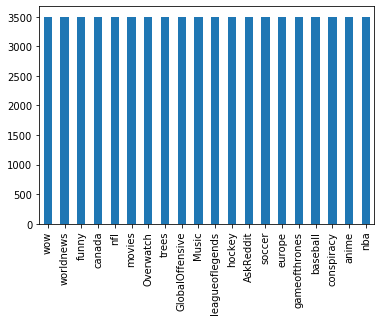

In [75]:
# based on tutorial from https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568

import logging
import pandas as pd
import numpy as np
from numpy import random
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup


df = pd.read_csv('reddit-comment-classification-comp-551/reddit_train.csv')
df = df[pd.notnull(df['comments'])]
print(df.head(20))
print(df['comments'].apply(lambda x: len(x.split(' '))).sum())

X_kaggle = pd.read_csv('reddit-comment-classification-comp-551/reddit_test.csv')
X_kaggle = X_kaggle[pd.notnull(X_kaggle['comments'])]
print(df.head(20))
print(X_kaggle['comments'].apply(lambda x: len(x.split(' '))).sum())

df.subreddits.value_counts().plot(kind='bar');


The classes are balanced, but the text needs cleaning. Here's some cleaning (we should customize **TODO: we should make something to remove links... that is words starting with `http://` at least, should be ignored**):

In [76]:
delimiters = re.compile('[/(){}\[\]\|@,;]')
ignored_symbols = re.compile('[^0-9a-z #+_]')
# nltk.download('stopwords')
stopwords = set(stopwords.words('english'))


# def print_plot(index):
#     example = df[df.index == index][['comments', 'subreddits']].values[0]
#     if len(example) > 0:
#         print(example[0])
#         print('subreddit:', example[1])


def clean_text(text):
    """
        text: a string (one comment)
        return: modified string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = delimiters.sub(' ', text) # replace delimiters symbols by space in text
    text = ignored_symbols.sub('', text) # delete symbols which are in ignored_symbols from text
    text = ' '.join(word for word in text.split() if word not in stopwords) # delete stopwords from text
    return text
    
df['comments'] = df['comments'].apply(clean_text)

#COMPETITION SET
X_kaggle['comments'] = X_kaggle['comments'].apply(clean_text)


Now to lemmatize the corpus.  This might not help in the short term, but will be useful to play with. 


In [77]:
from nltk.tokenize import word_tokenize

from nltk.stem import LancasterStemmer, PorterStemmer
#stemmer = LancasterStemmer()
stemmer = PorterStemmer()

def lemmatize_sentence(sen):
    """ lemmatizes every word in space separated sentence sen""" 
    token_list = word_tokenize(sen)
    lemma_sen = []
    for w in token_list:
        lemma_sen.append(stemmer.stem(w))
    return " ".join(lemma_sen)

df['comments'] = df['comments'].apply(lambda x: lemmatize_sentence(x))

# print_plot(1234)
print(df.head(10))

#COMPETITION SET
X_kaggle['comments'] = X_kaggle['comments'].apply(lambda x: lemmatize_sentence(x))
X_kaggle = pd.Series(X_kaggle['comments'], index=X_kaggle.index)
# print_plot(1234)

   id                                           comments       subreddits
0   0  honestli buffalo correct answer rememb peopl s...           hockey
1   1  ah ye way could rememb draft thought gon na gr...              nba
2   2  http youtub 6xxbbr8isz0t40m49sif didnt find al...  leagueoflegends
3   3  wouldnt bad sign wouldnt paid 18m euro right p...           soccer
4   4  easi use piss dri techniqu let drop let dri ri...            funny
5   5                              joke youiv seen twice            funny
6   6  role mi3 one best villian ive seen movi genuin...           movies
7   7  akagi still alpha fuck sugawara suffer definit...            anime
8   8  think other deton wouldnt proven joker right b...           movies
9   9  right disruptor tank pull dp frey pick get poi...        Overwatch


We could set the train test split here, or we could do some more processing

In [6]:
# X_train, X_test, y_train, y_test = train_test_split(df.comments, df.subreddits, test_size=0.3, random_state = 12)

In [78]:
values_array = np.unique(df.subreddits.values)

Defining a function to get **a list of words in the entire corpus of comments** (that is, `tokens`), and also **a list unique words** (that is `types`).

In [7]:
# import itertools

# tokens_list = df['comments'].apply(lambda x: word_tokenize(x)).values

# tokens = np.array(list(itertools.chain.from_iterable(tokens_list)))

# types, type_counts = np.unique(tokens, return_counts=True)

# print("number of tokens",len(tokens))
# print("number of types",len(types))

number of tokens 1601210
number of types 75440


Some words are more common than others.  We might want to do something with this. But for now it's just useful to have the information.  I'll make an uncommon-word list. We can remove them just like we did the stopwords. We'll do this later, with scikitlearn's CountVectorizer.

In [2]:
# common_words = types[type_counts > 20]
# len(common_words)

In [9]:
# def downsize_vocab(text):
#     text = ' '.join(word for word in text.split() if word in common_words) # keep only common words
#     return text
    
# df['comments'] = df['comments'].apply(downsize_vocab)

In [10]:
# tokens_list = df['comments'].apply(lambda x: word_tokenize(x)).values

# tokens = np.array(list(itertools.chain.from_iterable(tokens_list)))

# types, type_counts = np.unique(tokens, return_counts=True)

# print("number of tokens",len(tokens))
# print("number of types",len(types))

Now that it is cleand, set the train test split of the data.

In [79]:
X_train, X_test, y_train, y_test = train_test_split(df.comments, df.subreddits, test_size=0.3, random_state = 12)

In [12]:
#from sklearn.feature_extraction.text import TfidfTransformer
#tfidf = TfidfTransformer()
#X_tfidf = tfidf.fit_transform(X_tf)

In [13]:
# X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df.subreddits, test_size=0.3, random_state = 12)

## Running sklearn classifier models

In [84]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report

from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

from sklearn.naive_bayes import BernoulliNB
bernoulli_nb = Pipeline([
                         ('ct_vect', CountVectorizer(binary=True)),
                         ('tfidf', TfidfTransformer()),
                         ('clf', BernoulliNB(alpha=0.1)),
                        ])

from sklearn.naive_bayes import MultinomialNB
multinomial_nb = Pipeline([
                         ('ct_vect', CountVectorizer(binary=False)),
                         ('tfidf', TfidfTransformer()),
                         ('clf', MultinomialNB(alpha=0.1)),
                        ])

from sklearn.naive_bayes import ComplementNB
complement_nb = Pipeline([
                         ('ct_vect', CountVectorizer(binary=False)),
                         ('tfidf', TfidfTransformer()),
                         ('clf', ComplementNB(alpha=1)),
                        ])

from sklearn.linear_model import SGDClassifier
sgd = Pipeline([
                 ('ct_vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('clf', SGDClassifier(loss='modified_huber', penalty='l2',
                                       alpha=1e-4, random_state=27,
                                       max_iter=5, tol=None)),
                ])

from sklearn.neighbors import KNeighborsClassifier
knn = Pipeline([
                 ('ct_vect', CountVectorizer(ngram_range=(1,1))),
                 ('tfidf', TfidfTransformer()),
                 ('clf', KNeighborsClassifier(n_neighbors=300, weights = 'distance')),
                ])

from sklearn.linear_model import LogisticRegression
logreg = Pipeline([
                 ('ct_vect', CountVectorizer()), # works well with more features (all 75440 ...)
                 ('tfidf', TfidfTransformer()),
                 ('clf', LogisticRegression(penalty='l2',multi_class='ovr',solver='saga')),
                ])


from sklearn.ensemble import RandomForestClassifier
randfrst = Pipeline([
                 ('ct_vect', CountVectorizer(max_features=5000)),
                 ('feature_selection', SelectFromModel(LinearSVC(C=0.01, penalty="l1", dual=False))), # optional
                 ('tfidf', TfidfTransformer()),
                 ('clf', RandomForestClassifier(n_estimators=10)), # more estimators might be good, but slow
                ])

from sklearn.neural_network import MLPClassifier
mlp = Pipeline([
                 ('ct_vect', CountVectorizer(max_features=5000)),
                 ('tfidf', TfidfTransformer()),
                 ('clf', MLPClassifier(alpha=1, max_iter=100)),
                ])

from sklearn.linear_model import PassiveAggressiveClassifier
passaggr = Pipeline([
                 ('ct_vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('clf', PassiveAggressiveClassifier(fit_intercept=True,C=0.1)),
                ])

# now for comparing and majority voting:
from sklearn.ensemble import VotingClassifier
clf1 = LogisticRegression(penalty='l2',multi_class='ovr',solver='saga')
clf2 = MultinomialNB(alpha=0.1)
clf3 = ComplementNB(alpha=1)
clf4 = PassiveAggressiveClassifier(fit_intercept=True,C=0.1) # won't work with voting='soft'
clf5 = SGDClassifier(loss='modified_huber', penalty='l2',alpha=1e-4, random_state=27, max_iter=5, tol=None)
clf6 = KNeighborsClassifier(n_neighbors=300, weights = 'distance')

voting_clf = Pipeline([
    ('ct_vect', CountVectorizer(binary=False)),
    ('tfidf', TfidfTransformer()),
    ('clf' , VotingClassifier(estimators=
                              [('logreg', clf1), ('mnb', clf2), ('cnb', clf3)],
                              voting='soft',n_jobs=-1))
])




def paramsearch(modelpipeline):
    '''
    modelpipeline: sklearn.pipeline.Pipeline object 
    does gridsearch on the given pipeline on test split and prints classification report
    '''
    from sklearn.model_selection import GridSearchCV

    parameters = {
        #passagr
#         'clf__C':[0.5,0.1,0.01]
        #voting
        'clf__voting':['hard','soft'],
        'clf__estimators':[
            [('logreg', clf1), ('mnb', clf2), ('cnb', clf3)],
            [('logreg', clf1), ('mnb', clf2), ('cnb', clf3),('sgd', clf5)],
        ]
        #logreg
#         'ct_vect__ngram_range': [(1,1)],
#         'ct_vect__max_features': [1000,5000,74000],
#         'clf__multi_class':['ovr','multinomial'],
#         'clf__solver':['sag','saga'],
        
#       #knn
#         'ct_vect__ngram_range': [(1,1)],
#         'ct_vect__max_features': [5000,74000],
#         'clf__n_neighbors':[3,30],
        
        #bernoulli_nb
#         'ct_vect__ngram_range': [(1,1)],
#         'ct_vect__max_features': [10000],
#         'clf__alpha': [1,1e-2,1e-3],
        
        #sgd
#         'ct_vect__ngram_range': [(1,1),(1,2)],
#         'ct_vect__max_features': [5000],
#         'clf__alpha': [1e-3, 1e-5],
    }
    # run gridsearch for parameters with 3-fold cross validation
    gridsearch = GridSearchCV(modelpipeline, parameters, cv=3, iid=False, n_jobs=-1)
    gridsearch = gridsearch.fit(X_train, y_train)
    y_pred = gridsearch.predict(X_test)
#     print(gridsearch)
    print(gridsearch.best_params_)
    print(gridsearch.best_score_)
    print('accuracy %s' % accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=values_array))

    return gridsearch

def runmodel(modelpipeline):
    '''
    modelpipeline: sklearn.pipeline.Pipeline object 
    runs the given pipeline on test split and prints classification report
    '''
    modelpipeline.fit(X_train, y_train)
    y_pred = modelpipeline.predict(X_test)
    print(modelpipeline)
    print('accuracy %s' % accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred,target_names=values_array))

gridsearch = paramsearch(voting_clf)

# runmodel(knn)

{'clf__estimators': [('logreg', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)), ('mnb', MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)), ('cnb', ComplementNB(alpha=1, class_prior=None, fit_prior=True, norm=False))], 'clf__voting': 'hard'}
0.5552859862984136
accuracy 0.572047619047619
                 precision    recall  f1-score   support

      AskReddit       0.24      0.32      0.27      1039
GlobalOffensive       0.60      0.67      0.63      1028
          Music       0.57      0.69      0.62      1011
      Overwatch       0.66      0.71      0.68      1085
          anime       0.62      0.64      0.63      1067
       baseball       0.68      0.64      0.66      1091
         canada       0.4

In [81]:
#MAKE PREDICTIONS FOR THE HELDOUT COMPETITION SET
y_kaggle = gridsearch.predict(X_kaggle)
y_kaggle = pd.Series(y_kaggle, index=X_kaggle.index)
y_kaggle = pd.DataFrame(y_kaggle)
y_kaggle['Id_'] = y_kaggle.index
y_kaggle.insert(loc = 0, column = "Id", value = y_kaggle['Id_'])
y_kaggle = y_kaggle.drop(columns=['Id_'])
y_kaggle = y_kaggle.rename(columns={0: "Category"})
y_kaggle

,Id,Category
0,0,baseball
1,1,europe
2,2,anime
3,3,worldnews
4,4,movies
...,...,...
29995,29995,movies
29996,29996,AskReddit
29997,29997,GlobalOffensive
29998,29998,gameofthrones


In [71]:
y_kaggle.to_csv("predictions.csv", index=False, sep = ',') 

## Our own NB

In [165]:
def fit_naive_bayes(observations, y, num_features,smoothing):

    #Initialize marginal probability for each class
    count_class = np.array(20*[[0]])
    marg_prob = np.array(20*[[1]]) #Laplace smoothing, starting counts with 1

    #Initialize matrix of probabilities of observed features given k
    cond_prob_matrix = np.ones((20,num_features)) * smoothing

    
    #compute marginal probability of each class
    total_comments = y.shape[0]
    for j in range(total_comments):
        count_class[y[j]] += 1
    
    #Marginal probability for each class
    marg_prob = np.true_divide(count_class, total_comments)

    
    observ = observations.nonzero()
    for i in range(observations.shape[0]):
        feature_no = observ[1][i]
        comment_no = observ[0][i]
       
        comment_class = y[comment_no]
        cond_prob_matrix[comment_class][feature_no] += 1

    #divide each row of cond_prob_matrix by the count of comments per class
    for i in range(20):
        cond_prob_matrix[i] = np.true_divide(cond_prob_matrix[i], count_class[i])


    cond_prob_matrix = cond_prob_matrix.transpose()
    marg_prob = np.log(marg_prob)

    return marg_prob, cond_prob_matrix

In [166]:
classes = {
        "anime": 1,
        "AskReddit": 2,
        "baseball": 3,
        "canada": 4, 
        "conspiracy": 5, 
        "europe": 6, 
        "funny": 7, 
        "gameofthrones": 8, 
        "GlobalOffensive": 9,
        "hockey" :10, 
        "leagueoflegends": 11, 
        "movies": 12, 
        "Music": 13, 
        "nba":14, 
        "nfl":15, 
        "Overwatch":16, 
        "soccer":17, 
        "trees":18, 
        "worldnews":19, 
        "wow":0
    }

y_traindf = pd.DataFrame(y_train)
y_traindf['subreddits']= y_traindf['subreddits'].map(classes)
y_train_array = np.array(y_traindf['subreddits'])

In [167]:
cv = CountVectorizer(max_features=5000,binary=True)
X_train_tf = cv.fit_transform(X_train)
X_test_tf = cv.transform(X_test)

In [168]:
import time
start_time = time.time()

# from naive_bayes import fit_naive_bayes
prior, conditional = fit_naive_bayes(X_train_tf, y_train_array, X_train_tf.shape[1],0.1)

print("Took %s seconds." % (time.time() - start_time))

Took 0.20167088508605957 seconds.


In [169]:
ID_list = X_test.index.tolist()

In [170]:
from scipy import sparse

def predict_naive_bayes(id_list, observations, marg_prob, cond_prob_matrix):

    #log of inverse conditional probability matrix
    inv_cond_prob_matrix = np.ones((cond_prob_matrix.shape[0], cond_prob_matrix.shape[1]))
    inv_cond_prob_matrix = inv_cond_prob_matrix - cond_prob_matrix
    inv_cond_prob_matrix = sparse.csr_matrix(np.log(inv_cond_prob_matrix))

    #log of conditional probability matrix
    cond_prob_matrix = sparse.csr_matrix(np.log(cond_prob_matrix))
    
    # 0s become 1s, 1s become 0s
    sparse_ones = sparse.csr_matrix(np.ones((observations.shape[0], observations.shape[1])))
    complement_obs = sparse_ones - observations

    prob_per_class = np.dot(observations,cond_prob_matrix) + np.dot(complement_obs,inv_cond_prob_matrix)

    y = []
    for i in range(observations.shape[0]):
        prob_per_class[i] += marg_prob.transpose()
        y.append(np.argmax(prob_per_class[i]))

    id_list = np.array(id_list).transpose()

    matrix = np.stack((id_list, y)).transpose()
    df_pred = pd.DataFrame(matrix)

    return df_pred

In [171]:
predictions = predict_naive_bayes(ID_list, X_test_tf, prior, conditional)

In [172]:
predictions

,0,1
0,26505,2
1,16099,19
2,35596,2
3,62735,8
4,67323,6
...,...,...
20995,23873,9
20996,15156,18
20997,1645,15
20998,4919,4


In [173]:
y_testdf = pd.DataFrame(y_test)
y_testdf['subreddits']= y_testdf['subreddits'].map(classes)
y_test_array = np.array(y_testdf['subreddits'])

In [174]:
predictions[1]

0         2
1        19
2         2
3         8
4         6
         ..
20995     9
20996    18
20997    15
20998     4
20999     4
Name: 1, Length: 21000, dtype: int64

In [175]:
def accuracy(df_pred, df_true_y):

    pred = np.array(df_pred[1])
    true_y = np.array(df_true_y['subreddits'])

    count = 0
    total = len(true_y)
    for i in range(total):
        if pred[i] == true_y[i]:
            count +=1
            
    return float(count)/total

In [178]:
accuracy(predictions, y_testdf)
print(classification_report(y_testdf['subreddits'], predictions[1],target_names=values_array))

accuracy 0.2924285714285714


In [227]:
class AnotherBernoulliNB(object):
    ''' based on https://kenzotakahashi.github.io/naive-bayes-from-scratch-in-python.html '''
    def __init__(self, alpha = 1.0):
        self.alpha = alpha

    def fit(self, X, y):
        count_sample = X.shape[0]
        separated = [[x for x, t in zip(X, y) if t == c] for c in np.unique(y)]
        self.class_log_prior_ = [np.log(len(i) / count_sample) for i in separated]
        count = np.array([np.array(i).sum(axis=0) for i in separated]) + self.alpha
        smoothing = 2 * self.alpha
        n_doc = np.array([len(i) + smoothing for i in separated])
        self.feature_prob_ = count / n_doc[np.newaxis].T
        return self

    def predict_log_proba(self, X):
        return [(np.log(self.feature_prob_) * x + \
                 np.log(1 - self.feature_prob_) * np.abs(x - 1)
                ).sum(axis=1) + self.class_log_prior_ for x in X]

    def predict(self, X):
        return np.argmax(self.predict_log_proba(X), axis=1)

In [229]:
nb = BernoulliNB(alpha=0.1)
nb.fit(X_train_tf,y_train)

BernoulliNB(alpha=0.1, binarize=0.0, class_prior=None, fit_prior=True)

In [230]:
newpredictions = nb.predict(X_test_tf)

In [231]:
prediction_df = pd.DataFrame(y_test)
prediction_df['subreddits'] = pd.DataFrame(newpredictions)[0].values
prediction_df

,subreddits
26505,funny
16099,AskReddit
35596,AskReddit
62735,gameofthrones
67323,baseball
...,...
23873,funny
15156,trees
1645,soccer
4919,trees


In [232]:
print('accuracy %s' % accuracy_score(y_test, prediction_df))
print(classification_report(y_testdf['subreddits'], predictions[1],target_names=values_array))

accuracy 0.45871428571428574
                 precision    recall  f1-score   support

      AskReddit       0.40      0.45      0.42      1020
GlobalOffensive       0.29      0.42      0.34      1067
          Music       0.12      0.12      0.12      1039
      Overwatch       0.49      0.15      0.23      1091
          anime       0.15      0.58      0.24      1012
       baseball       0.20      0.22      0.21      1019
         canada       0.28      0.29      0.28      1084
     conspiracy       0.17      0.05      0.08      1053
         europe       0.42      0.54      0.47      1050
          funny       0.40      0.30      0.34      1028
  gameofthrones       0.35      0.24      0.28      1013
         hockey       0.37      0.31      0.33      1013
leagueoflegends       0.29      0.24      0.26      1054
         movies       0.31      0.52      0.39      1011
            nba       0.49      0.22      0.30      1074
            nfl       0.49      0.18      0.26      1042
 